In [ ]:
import sys
!{sys.executable} -m pip install scanpy anndata igraph

In [20]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc


In [21]:
# Set plotting parameters
sc.settings.set_figure_params(dpi=100, facecolor='white')
%matplotlib inline


In [22]:
# Define the path to the processed directory
processed_dir = r"C:\PRASHANTH\github projects\CellTrajectory-Developmental-Path-Modeling-System\data\processed"
print(f"Using data from: {processed_dir}")

Using data from: C:\PRASHANTH\github projects\CellTrajectory-Developmental-Path-Modeling-System\data\processed


In [23]:
# Check if the file exists
adata_file = os.path.join(processed_dir, "velten_hematopoiesis_raw.h5ad")
if os.path.exists(adata_file):
    print(f"Found AnnData file: {adata_file}")
else:
    print(f"ERROR: AnnData file not found at: {adata_file}")
    print("Please make sure the path is correct.")

Found AnnData file: C:\PRASHANTH\github projects\CellTrajectory-Developmental-Path-Modeling-System\data\processed\velten_hematopoiesis_raw.h5ad


In [24]:
# Load the AnnData object
adata = sc.read_h5ad(adata_file)
print(f"Loaded data with shape: {adata.shape}")

Loaded data with shape: (2413, 22076)


In [26]:
# Examine the data structure
print("\nData structure:")
print(f"Number of cells: {adata.n_obs}")
print(f"Number of genes: {adata.n_vars}")
print(f"Metadata columns: {adata.obs.columns.tolist()}")


Data structure:
Number of cells: 2413
Number of genes: 22076
Metadata columns: ['sample_id', 'plate', 'well_letter', 'well_number']


In [29]:
# Display sample metadata
print("\nSample metadata:")
print(adata.obs.head())

# Calculate quality control metrics
print("\nCalculating QC metrics...")
sc.pp.calculate_qc_metrics(adata, inplace=True)


Sample metadata:
                        sample_id   plate well_letter well_number  \
GSM1955701_plate3_A_1  GSM1955701  plate3           A           1   
GSM1955702_plate3_A_2  GSM1955702  plate3           A           2   
GSM1955703_plate3_A_3  GSM1955703  plate3           A           3   
GSM1955704_plate3_A_4  GSM1955704  plate3           A           4   
GSM1955705_plate3_A_5  GSM1955705  plate3           A           5   

                       n_genes_by_counts  log1p_n_genes_by_counts  \
GSM1955701_plate3_A_1                 62                 4.143135   
GSM1955702_plate3_A_2               4455                 8.402007   
GSM1955703_plate3_A_3                243                 5.497168   
GSM1955704_plate3_A_4                390                 5.968708   
GSM1955705_plate3_A_5                526                 6.267201   

                       total_counts  log1p_total_counts  \
GSM1955701_plate3_A_1         24382           10.101641   
GSM1955702_plate3_A_2       119419

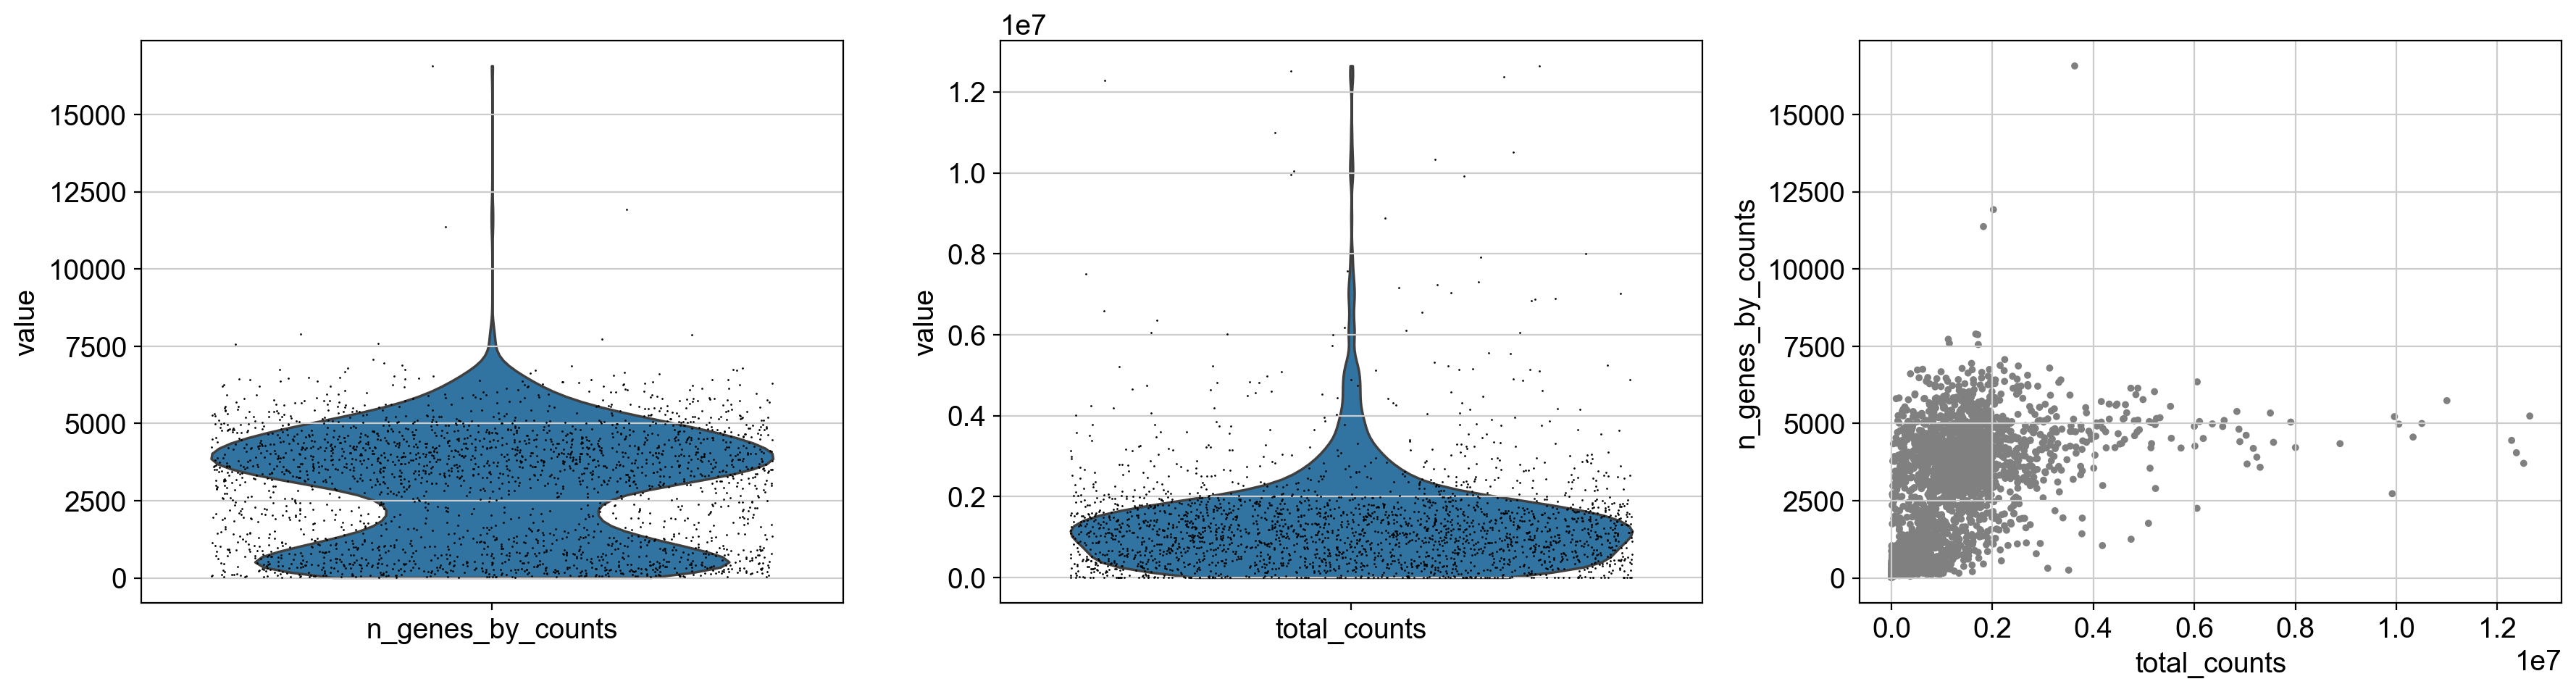

In [30]:
# Plot QC metrics
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
sc.pl.violin(adata, 'n_genes_by_counts', jitter=0.4, ax=axs[0], show=False)
sc.pl.violin(adata, 'total_counts', jitter=0.4, ax=axs[1], show=False)
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', ax=axs[2], show=False)
plt.tight_layout()
plt.show()

In [31]:
# Filter cells and genes
min_genes = 200
print(f"\nFiltering cells with less than {min_genes} genes...")
sc.pp.filter_cells(adata, min_genes=min_genes)

min_cells = 3
print(f"Filtering genes expressed in less than {min_cells} cells...")
sc.pp.filter_genes(adata, min_cells=min_cells)

print(f"After filtering: {adata.n_obs} cells, {adata.n_vars} genes")


Filtering cells with less than 200 genes...
filtered out 136 cells that have less than 200 genes expressed
Filtering genes expressed in less than 3 cells...
filtered out 3063 genes that are detected in less than 3 cells
After filtering: 2277 cells, 19013 genes


In [32]:

# Normalize data
print("\nNormalizing data...")
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)



Normalizing data...
normalizing counts per cell
    finished (0:00:00)


Finding highly variable genes...
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


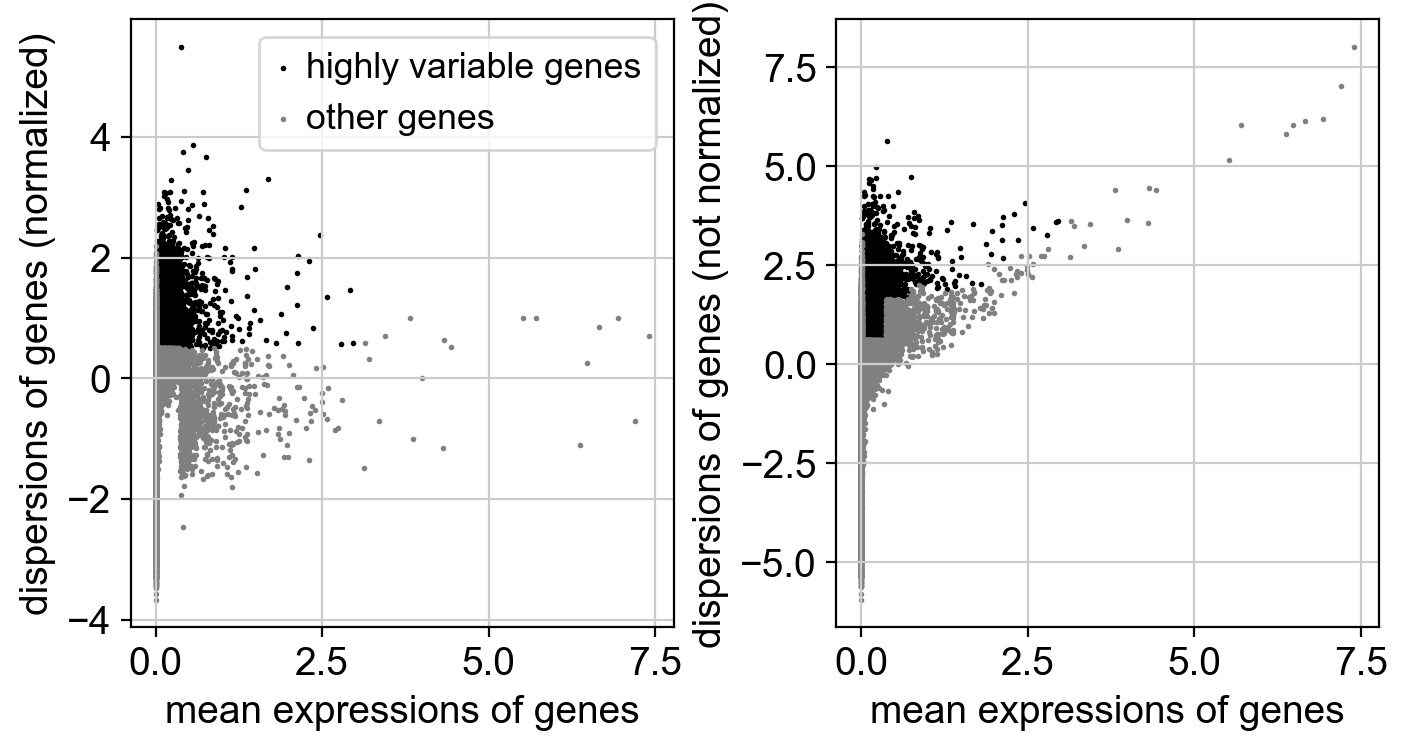

Number of highly variable genes: 4955


In [33]:
# Identify highly variable genes
print("Finding highly variable genes...")
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

# Filter to highly variable genes
adata = adata[:, adata.var.highly_variable]
print(f"Number of highly variable genes: {adata.n_vars}")


Scaling data...


c:\Users\PRASHANTH\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Running PCA...
computing PCA
    with n_comps=50
    finished (0:00:01)


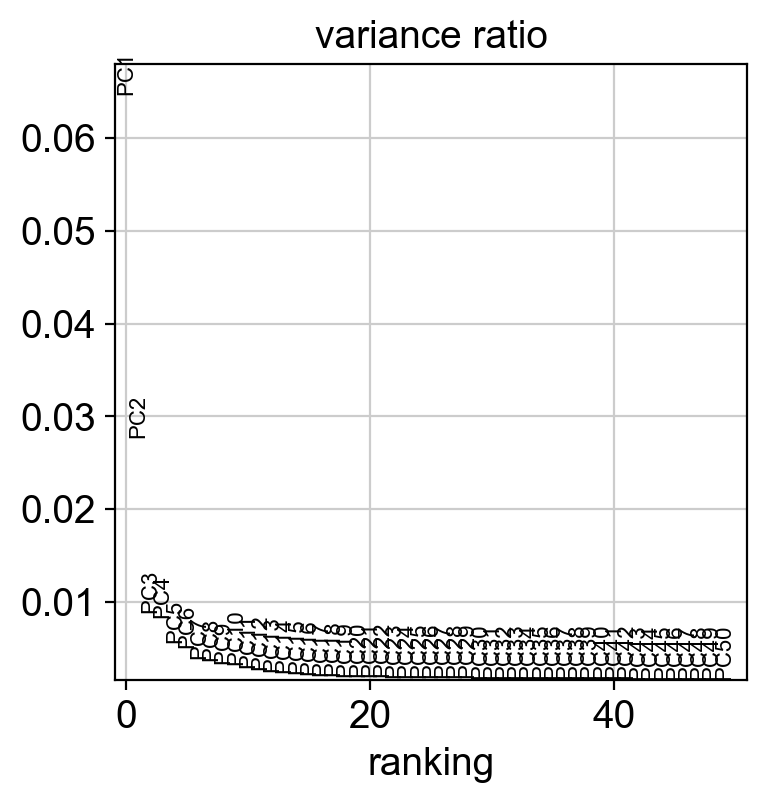

Optimal number of PCs: 35
Computing neighborhood graph...
computing neighbors
    using 'X_pca' with n_pcs = 35


c:\Users\PRASHANTH\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:18)


In [34]:
# Scale data
print("Scaling data...")
sc.pp.scale(adata, max_value=10)

# Run PCA
print("Running PCA...")
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, n_pcs=50)

# Determine optimal number of PCs
knee_point = np.argmax(np.diff(np.diff(np.cumsum(adata.uns['pca']['variance_ratio']))))
optimal_pcs = knee_point + 2
print(f"Optimal number of PCs: {optimal_pcs}")

# Compute neighborhood graph
print("Computing neighborhood graph...")
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=optimal_pcs)


Running UMAP...
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:07)


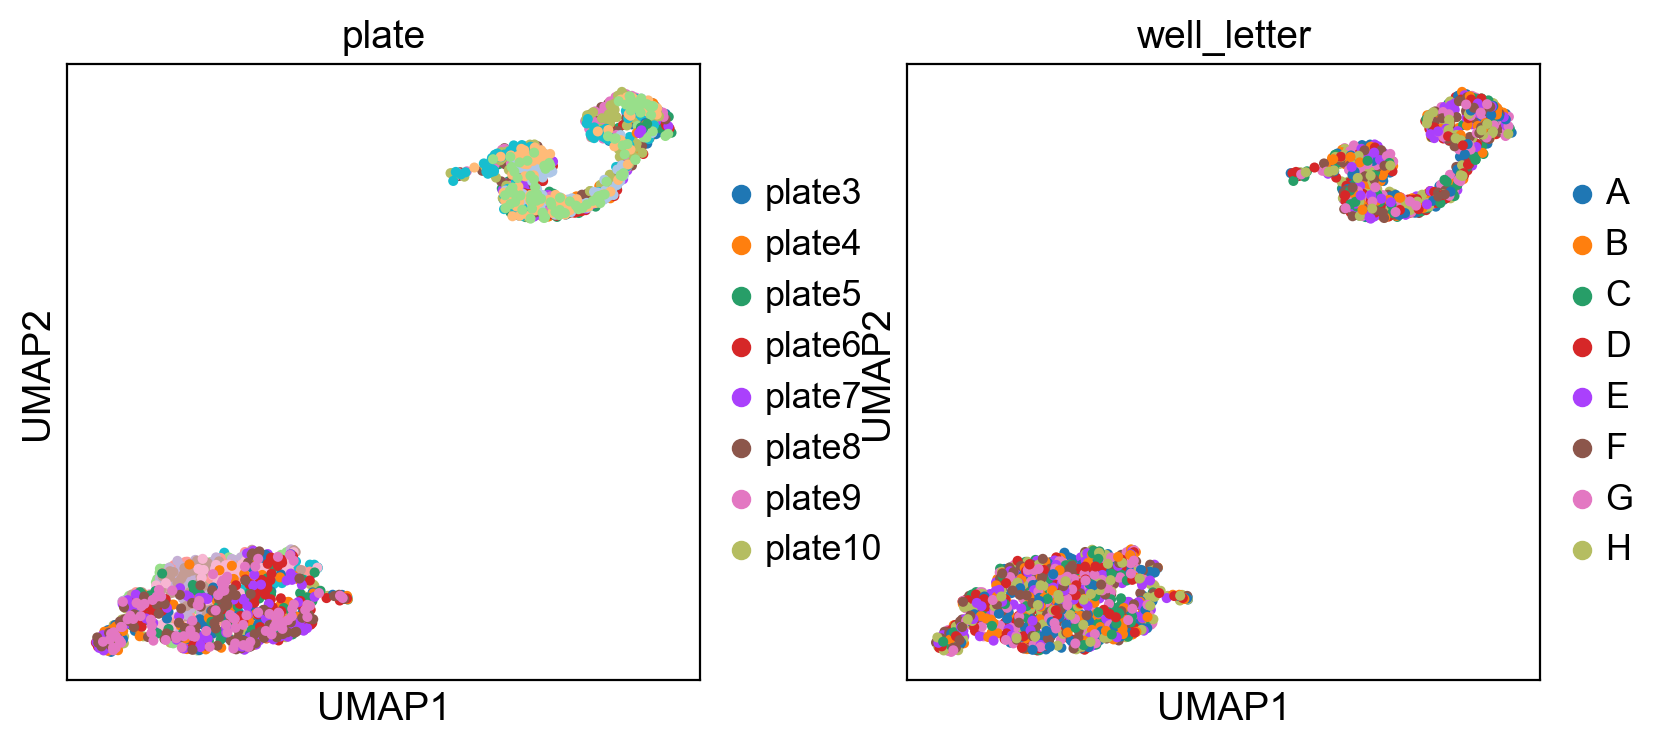

In [35]:
# Run UMAP
print("Running UMAP...")
sc.tl.umap(adata)
sc.pl.umap(adata, color=['plate', 'well_letter'] if 'plate' in adata.obs.columns and 'well_letter' in adata.obs.columns else None)

In [40]:
pip install leidenalg

     ---------------------------------------- 1.6/1.6 MB 12.5 MB/s eta 0:00:00
     ---------------------------------------- 2.9/2.9 MB 47.1 MB/s eta 0:00:00
  Attempting uninstall: igraph
    Found existing installation: igraph 1.0.0
    Uninstalling igraph-1.0.0:
      Successfully uninstalled igraph-1.0.0
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'c:\Users\PRASHANTH\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Clustering cells...
running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


C:\Users\PRASHANTH\AppData\Local\Temp\ipykernel_25796\3051914669.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5)


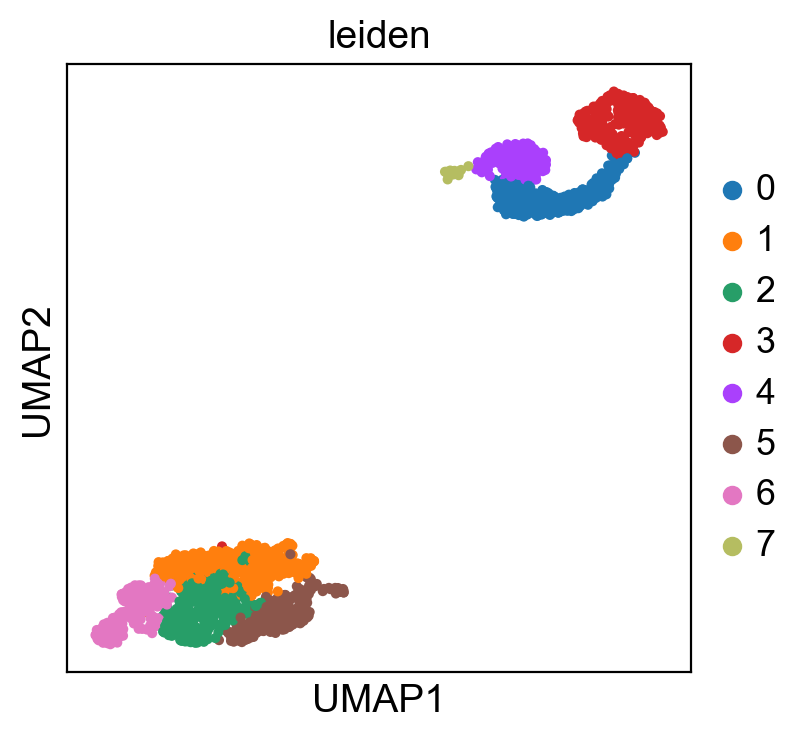

In [41]:
# Cluster the cells
print("Clustering cells...")
sc.tl.leiden(adata, resolution=0.5)
sc.pl.umap(adata, color='leiden')

Finding marker genes for each cluster...
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:09)


c:\Users\PRASHANTH\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\tools\_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
c:\Users\PRASHANTH\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\tools\_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
c:\Users\PRASHANTH\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\tools\_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
c:\Users\PRASHANTH\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\tools\_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
c:\Users\PRASHANTH\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\tools\_rank_genes_groups.py:484:

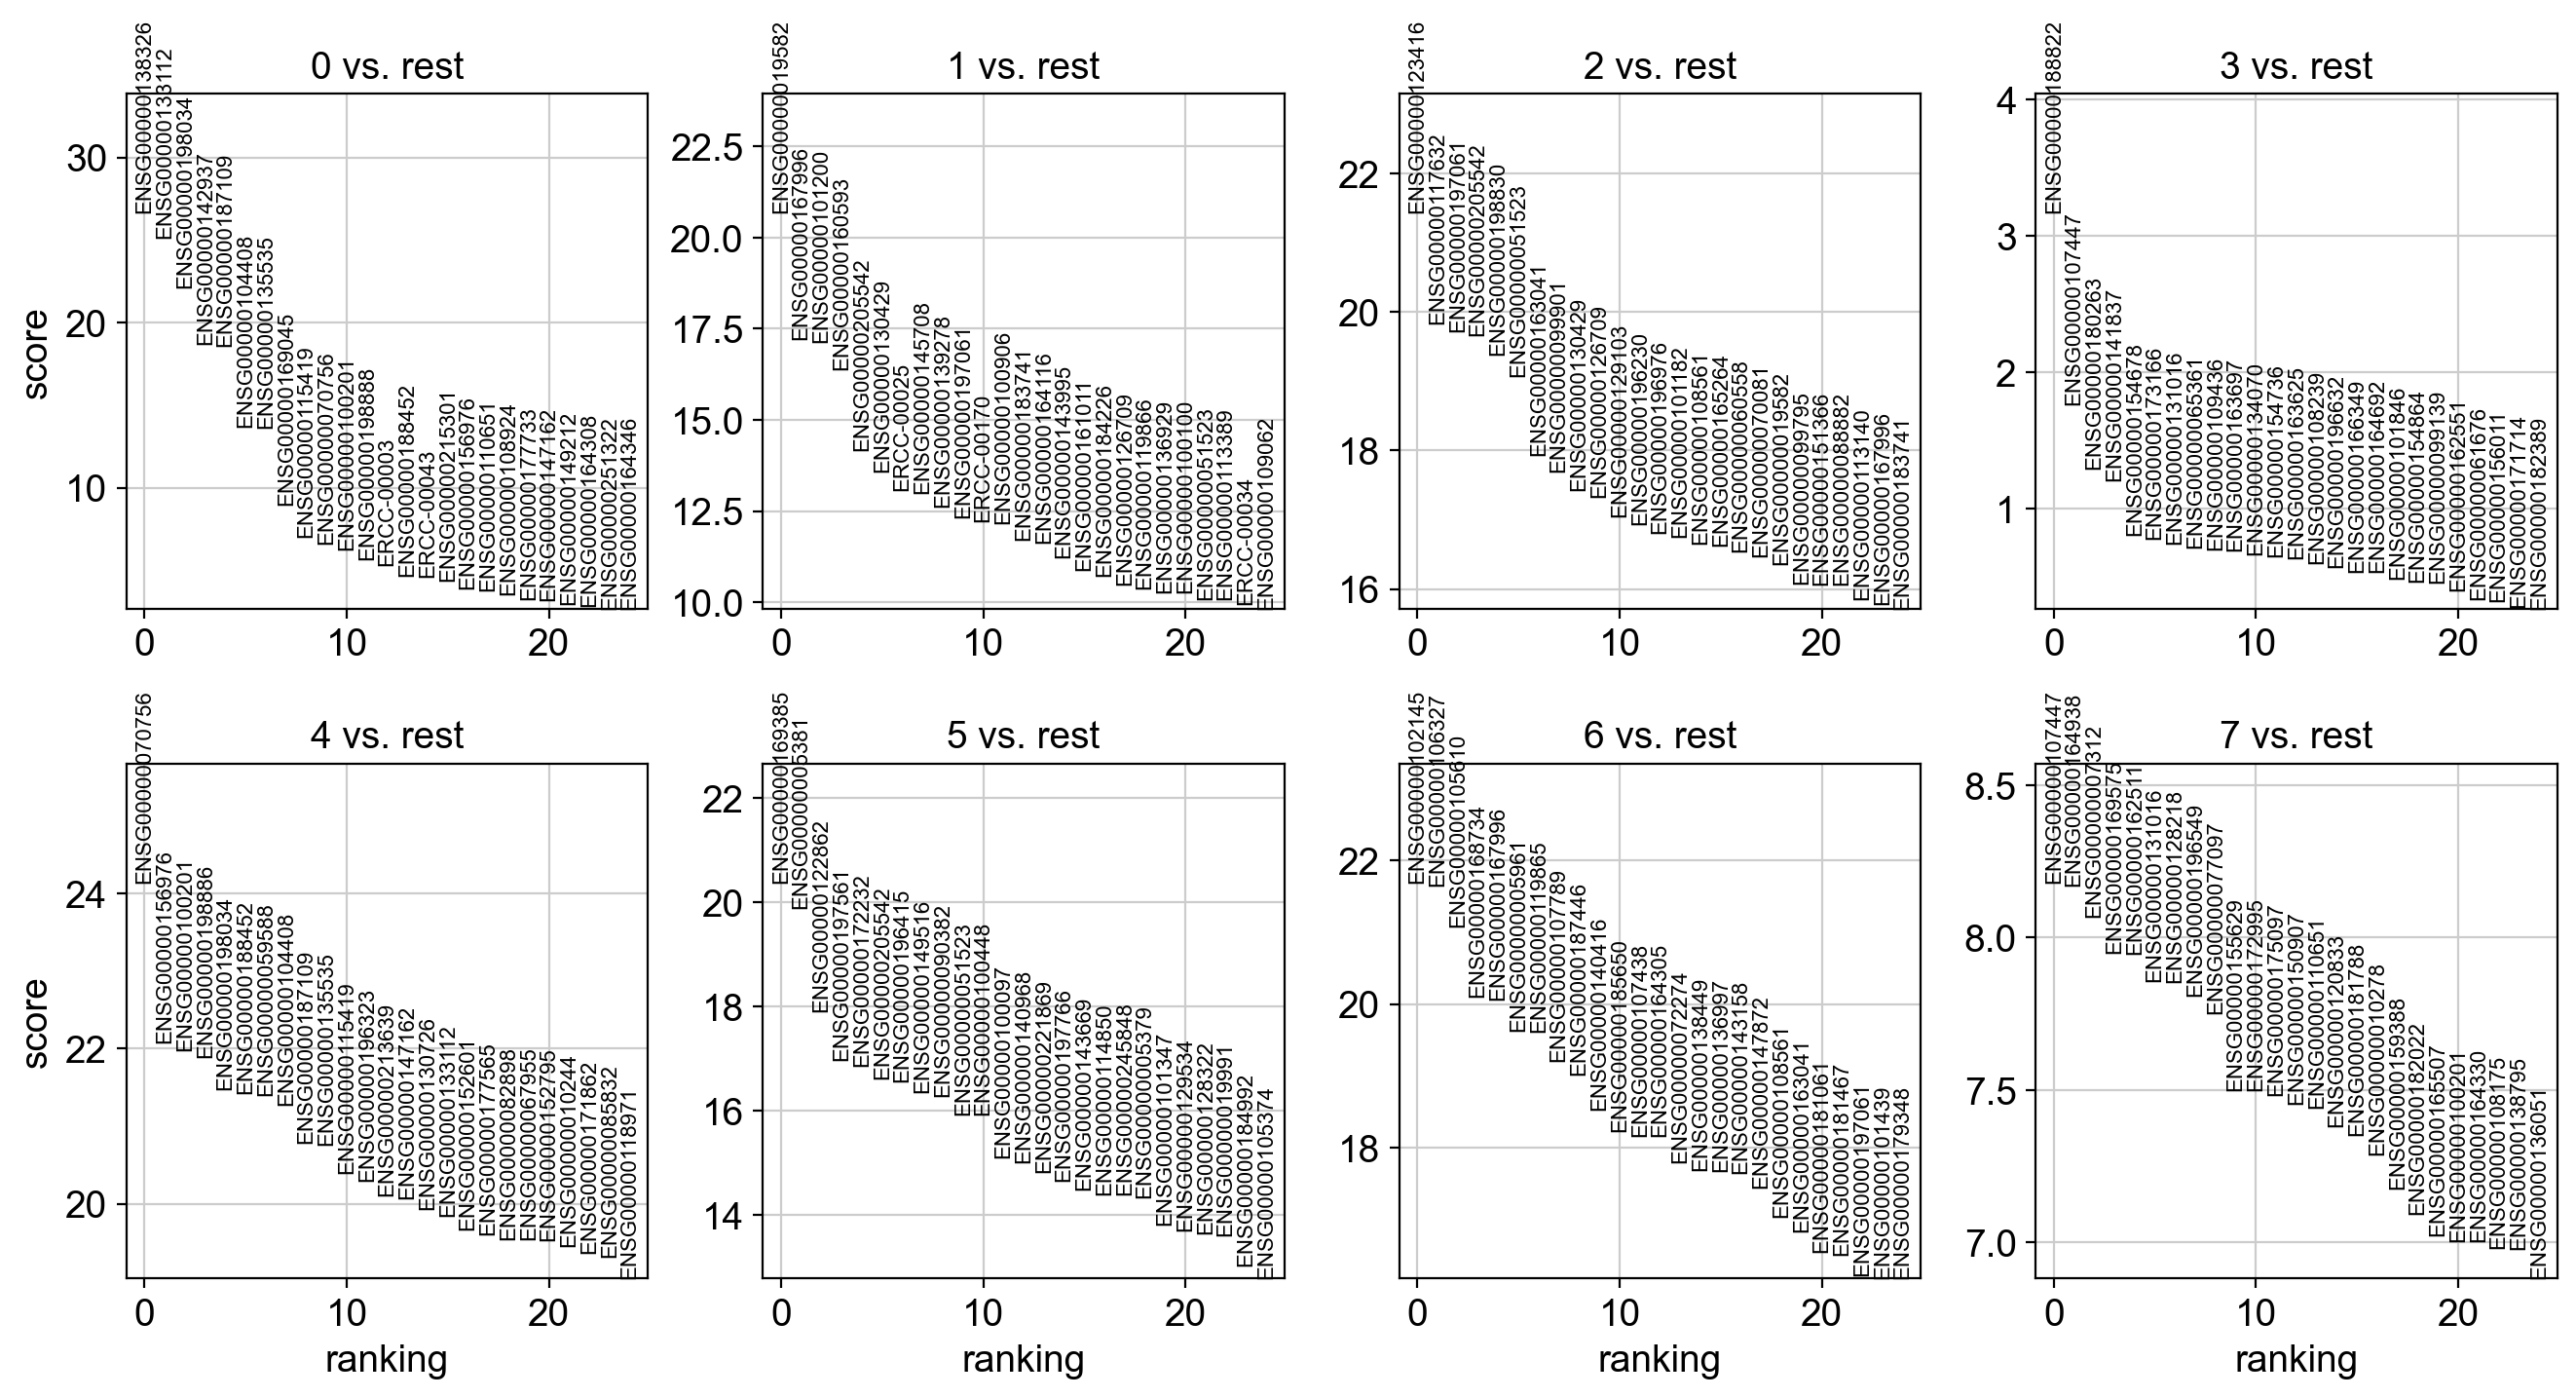

In [42]:
# Find marker genes
print("Finding marker genes for each cluster...")
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [43]:
# Identify cell types based on marker genes
# Define marker genes for hematopoietic populations
cell_type_markers = {
    'HSC': ['CD34', 'GATA2', 'HLF', 'CRHBP', 'HOPX', 'MLLT3'],
    'MPP': ['CD34', 'PROM1', 'SPINK2', 'ADGRG1'],
    'LMPP': ['CD34', 'FLT3', 'PROM1', 'SPN'],
    'CLP': ['CD34', 'MME', 'DNTT', 'SPINK2', 'IGLL1', 'ADA'],
    'GMP': ['CD34', 'CSF3R', 'PRTN3', 'MPO', 'ELANE'],
    'MEP': ['CD34', 'GATA1', 'KLF1', 'HBD', 'CA1'],
    'B cell progenitor': ['CD19', 'MS4A1', 'CD79A', 'CD79B', 'VPREB1'],
    'Monocyte': ['CD14', 'FCGR3A', 'S100A8', 'S100A9', 'LYZ'],
    'Erythroid progenitor': ['GATA1', 'GYPA', 'KLF1', 'HBB', 'CA1'],
    'T cell progenitor': ['CD3D', 'CD3E', 'CD3G', 'CD8A', 'IL7R']
}

# Calculate score for each cell type
for cell_type, markers in cell_type_markers.items():
    # Filter for markers actually in the dataset
    available_markers = [marker for marker in markers if marker in adata.var_names]
    if available_markers:
        sc.tl.score_genes(adata, available_markers, score_name=f'{cell_type}_score')
    else:
        print(f"Warning: No markers found for {cell_type}")

# Create cell type annotation based on highest score
score_cols = [col for col in adata.obs.columns if col.endswith('_score')]
if score_cols:
    adata.obs['predicted_cell_type'] = adata.obs[score_cols].idxmax(axis=1)
    adata.obs['predicted_cell_type'] = adata.obs['predicted_cell_type'].str.replace('_score', '')

    # Visualize predicted cell types
    sc.pl.umap(adata, color='predicted_cell_type', legend_loc='on data')

In [44]:
processed_file = os.path.join(processed_dir, "velten_hematopoiesis_processed.h5ad")
print(f"\nSaving processed data to: {processed_file}")
adata.write(processed_file)
print("Preprocessing complete!")


Saving processed data to: C:\PRASHANTH\github projects\CellTrajectory-Developmental-Path-Modeling-System\data\processed\velten_hematopoiesis_processed.h5ad
Preprocessing complete!
